In [179]:
%pip install -q matplotlib pandas numpy scikit-learn auto-sklearn

Note: you may need to restart the kernel to use updated packages.


In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.metrics import r2_score


In [181]:
df = pd.read_csv("6V_all-axis_fast.txt", sep=r"\s+", header=None)

df.columns = [
    "timestep",
    "x_in", "x_in_scaled",
    "y_in", "y_in_scaled",
    "z_in", "z_in_scaled",
    "x_out", "y_out", "z_out"
]
file_format = df.columns

print(df.head(10))
print("Shape:", df.shape)

     timestep        x_in  x_in_scaled        y_in  y_in_scaled       z_in  \
0  4226439499    0.000000            0    0.000000            0   0.000000   
1  4226439500  166.909218     10938562  177.002152     11600013  16.229296   
2  4226439501  167.976277     11008493  177.382261     11624923  13.580543   
3  4226439502  169.025740     11077270  177.786055     11651386  10.939399   
4  4226439503  170.057600     11144894  178.213424     11679394   8.306029   
5  4226439504  171.071854     11211365  178.664255     11708940   5.680600   
6  4226439505  172.068498     11276681  179.138427     11740015   3.063275   
7  4226439506  173.047532     11340843  179.635819     11772613   0.454220   
8  4226439507  174.008957     11403850  180.156305     11806723  -2.146402   
9  4226439508  174.952776     11465705  180.699753     11842339  -4.738428   

   z_in_scaled     x_out         y_out       z_out  
0            0  7491.712 -7.662780e+13 -633441.408  
1      1063603  7505.280 -7.662799e

Try doing a simple windowed regression in sklearn. Then try auto ml once the data is prepared right.

0.9985978140272822


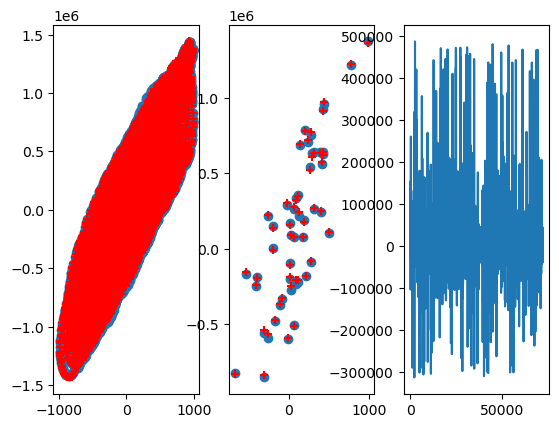

In [182]:

WINDOW_LEN = 30

x_in = df["x_in"].values.reshape(360001, 1)
x_in.setflags(write=False)
x_out = df["x_out"].values.reshape(360001, 1)

def windowed_linear_regression(X,Y, window_size):

    regressor = LinearRegression()

    X_window = sliding_window_view(X, WINDOW_LEN, 0)
    X_window = np.squeeze(X_window)
    y_truncated = np.delete(Y, slice(0,WINDOW_LEN-1))

    X_train, X_test, y_train, y_test = train_test_split(X_window, y_truncated, test_size=0.2, random_state=42)

    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)

    print(r2_score(y_test, y_pred))

    plt.subplot(1, 3, 1)
    plt.scatter(X_test[:, -1], y_test[:], )
    plt.scatter(X_test[:, -1], y_pred[:], color="red", marker="+")

    plt.subplot(1, 3, 2)
    plt.scatter(X_test[:50,-1], y_test[:50], )
    plt.scatter(X_test[:50, -1], y_pred[:50], color="red", marker="+")

    plt.subplot(1,3,3)
    plt.plot(y_pred-y_test)

windowed_linear_regression(x_in,x_out,WINDOW_LEN)

The plot is no longer useful i guess the best plot would track a path through the space.

-0.0001574279573721693


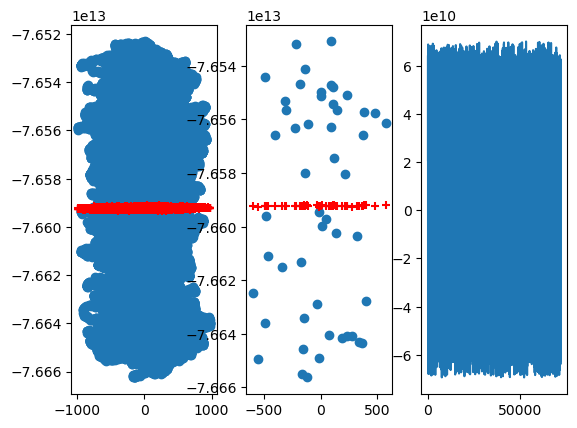

In [183]:
y_in = df["y_in"].values.reshape(360001, 1)
y_in.setflags(write=False)
y_out = df["y_out"].values.reshape(360001, 1)
windowed_linear_regression(y_in,y_out,WINDOW_LEN)

What if we can show a deviation

0.9726737811396389


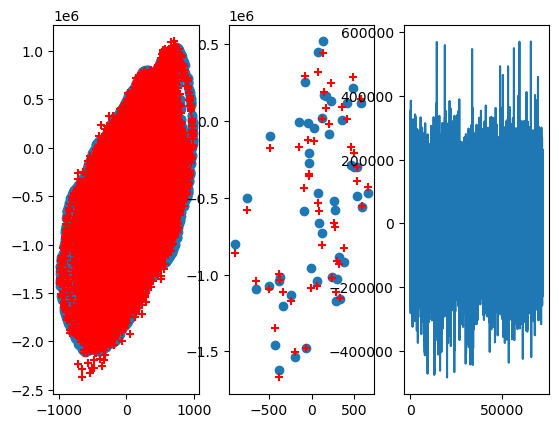

In [184]:
z_in = df["z_in"].values.reshape(360001, 1)
z_in.setflags(write=False)
z_out = df["z_out"].values.reshape(360001, 1)
windowed_linear_regression(z_in,z_out,WINDOW_LEN)

Next lets try adding more dimensions and doing the same thing

In [185]:
X = df["x_in"].values.reshape(360001, 1)
X.setflags(write=False)
Y = df["x_out"].values.reshape(360001, 1)